In [1]:
import gym
import json
import datetime as dt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from gym import wrappers

import matplotlib.pyplot as plt
import time

In [2]:
from env.StockTradingEnv import StockTradingEnv
from networks.DQNac import MyModel
from networks.DQNac import StockActor, StockCritic, DQN

In [3]:
df = pd.read_csv('./data/IBM_train.csv')
df = df.sort_values('Date')

# The algorithms require a vectorized environment to run
env = StockTradingEnv(df)



mod = MyModel(32, (1,4), (1,1))

print(obs)
z = mod.predict(obs)
print(z)


act = StockActor()
act_target = StockActor()
output_action = act(obs)
output_action_tar = act_target(obs)
print("output_action")
print(output_action)
print(" ")
print("output_action_tar")
print(output_action_tar)
print(" ")
output_action = act(obs)
output_action_tar = act_target(obs)
print("output_action2")
print(tf.squeeze(output_action))
print(" ")
print("output_action_tar2")
print(output_action_tar)
print(" ")

#act.model.summary()
#print(act.model.layers[3].get_weights())
#act.model.layers[3].set_weights([np.array([[-0.3]], dtype=np.float32), np.array([0.1], dtype=np.float32)])
#print(act.model.layers[3].get_weights())

crit = StockCritic()
act = StockActor()

output_action = act(obs)
print(output_action)
output_action = tf.squeeze(output_action)
output_crit = crit([obs,output_action])
print(output_crit)

    
gamma = 0.99
max_experiences = 1000
min_experiences = 365
batch_size = 32
lr = 1e-2
D = DQN( gamma, max_experiences, min_experiences, batch_size, lr)
observations = env.reset()
observations = np.expand_dims(observations,axis=0)
observations = np.expand_dims(observations,axis=0)
D.act(observations)

a = act.model.trainable_variables
print(a)
print(" ")
print(" ")
print(" hjkbedfhugqdfhiqdfbhiqdf")
print(" ")
print(" ")
b = act.trainable_variables
print(b)


#model = MyModel(32, (1,4), (1,1))
#output=tf.squeeze(model(obs))

crit = StockCritic()
crit_tar = StockCritic()
crit.action = tf.squeeze(output_action)
crit_tar.action = tf.squeeze(output_action)
output = crit(obs)
output_tar = crit_tar(obs)
print("output")
print(output)
print(" ")
print("output_tar")
print(output_tar)
print(" ")
crit.action = tf.squeeze(output_action_tar)
crit_tar.action = tf.squeeze(output_action)
output = crit(obs)
output_tar = crit_tar(obs)
print("output2")
print(output)
print(" ")
print("output_tar2")
print(output_tar)
print(" ")
print(crit.trainable_variables)

### Additional functions

In [10]:

def fill_buffer(env, DQN,alpha,sigma):
    
    
    rewards = 0
    iter = 0
    done = False
    observations = env.reset()
    observations = np.expand_dims(observations,axis=0)
    observations = np.expand_dims(observations,axis=0)
    steps = 0
    it=0
    while it<DQN.min_experiences:
        
        #print(it)
        #observations = env.reset()

        action = DQN.act(observations) # observations is actually a single "state" ie past 5 days
        action = tf.squeeze(action)+alpha*np.random.normal(0,sigma)
        #action = np.tanh(tf.squeeze(action)+np.random.normal(0,0.05)) #avoiding small action values in the begining ->[2 0] to frequently
        #print(action)
        action = DQN.convert_action(action)
         
        #print(action)
        prev_observations = observations
        observations, reward, done, _ = env.step(action)
        #print(reward)
        observations = np.expand_dims(observations,axis=0)
        observations = np.expand_dims(observations,axis=0)
        rewards += reward    # sum of gain_net_worth

        if done :
            print("DONE")
#             reward = -200
            env.reset()
        steps += 1
        if steps >= 300: # Limiting the number of steps
            print("STEPS")
            observations = env.reset()
            observations = np.expand_dims(observations,axis=0)
            observations = np.expand_dims(observations,axis=0)
            steps = 0
        
        obs = tf.squeeze(observations)
        obs = np.expand_dims(obs,axis=0)
        prev_observations = tf.convert_to_tensor(prev_observations)
        prev_observations = tf.squeeze(prev_observations, axis=0)
        exp = {'s': prev_observations, 'a': action, 'r': reward, 's2': obs, 'done': done}
        DQN.add_experience(exp)
        
        it += 1
    return " Done "

def DDPG(M,T,lrc,lra,alpha,sigma):                       # M number of episode T lenght of an episode
    
    gamma = 0.9998
    max_experiences = 1000
    min_experiences = 365
    batch_size = 32
    lr_crit = lrc               #optimal 1e-1
    lr_act = lra                #optimal 1e-3
 
    D = DQN( gamma, max_experiences, min_experiences, batch_size, lr_crit,lr_act)
    a = fill_buffer(env, D,alpha,sigma)
    #print(a)
    table_loss =[]
    table_actions_explored = []
    for i in range(M):
        agent = D.train(env,T,table_loss,table_actions_explored,alpha,sigma)
    print("done")
    return agent,D,table_loss,table_actions_explored



In [5]:
#to do the graphs 

def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

agent_a ,D,table_loss_a,table_actions_explored_a = DDPG(50,100,1e-1,1e-3,1,0.1)
agent_b ,D,table_loss_b,table_actions_explored_b = DDPG(50,100,1e-1,1e-3,1,0.15)  #agent the act network
agent_c ,D,table_loss_c,table_actions_explored_c = DDPG(50,100,1e-1,1e-3,1,0.2)
agent_d ,D,table_loss_d,table_actions_explored_d = DDPG(50,100,1e-1,1e-3,1,0.25)

agents = [agent_a,agent_b,agent_c,agent_d]
table_loss = [table_loss_a,table_loss_b,table_loss_c,table_loss_d]
table_actions_explored = [table_actions_explored_a,table_actions_explored_b,table_actions_explored_c,table_actions_explored_d]


In [50]:
agents = []
table_loss = []
table_actions_explored = []

for i in range(10):
    agent ,D,t_loss,ta_explored = DDPG(20,100,1e-1,1e-3,1,0.1)
    agents.append(agent)
    table_loss.append(t_loss)
    table_actions_explored.append(ta_explored )
    
    
    


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

STEPS

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you in

done

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

STEPS

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If y

C:\Users\Thomas\PycharmProjects\reinforcement-learning-master\P3A-Deep-Reinforcement-Learning\Stock-Trading-Environment\env\StockTradingEnv.py:107: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


done

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

STEPS

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If y

done

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

STEPS

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If y

C:\Users\Thomas\PycharmProjects\reinforcement-learning-master\P3A-Deep-Reinforcement-Learning\Stock-Trading-Environment\env\StockTradingEnv.py:107: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)


done

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

STEPS

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If y

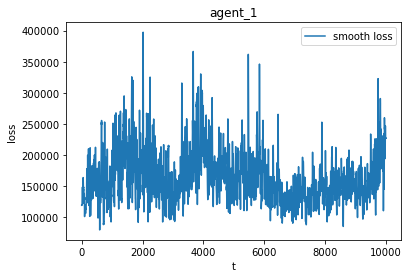

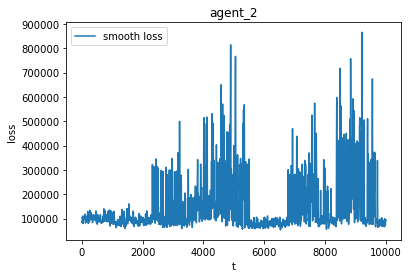

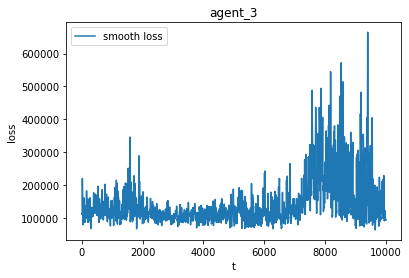

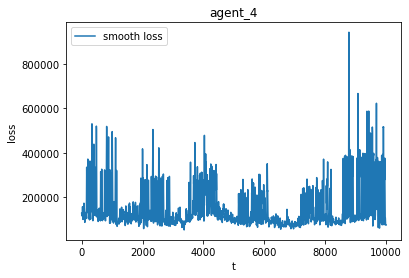

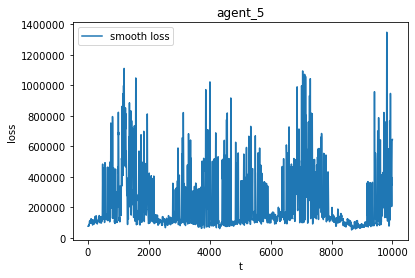

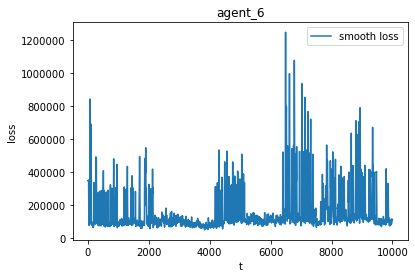

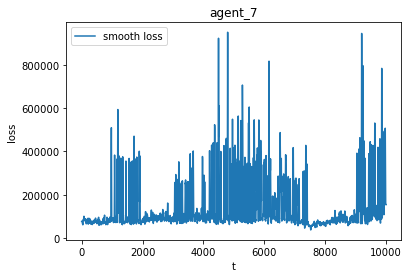

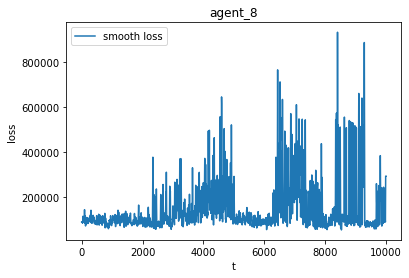

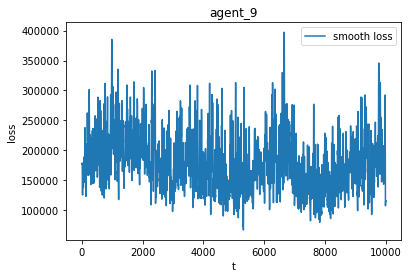

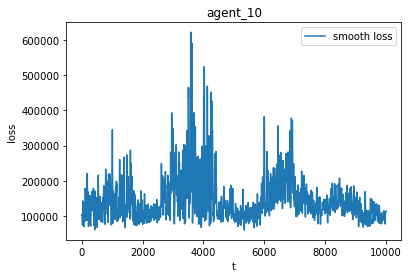

In [21]:
t = np.arange(0, 10000, 1)
table_loss  = np.asarray(table_loss)
count=1
for tl in table_loss:
    s = smoothTriangle(tl, 10)
    #plt.plot(t,table_loss,label="loss")
    plt.plot(t,s,label="smooth loss")
    plt.xlabel("t")
    plt.ylabel("loss")
    plt.legend()
    plt.title("agent_{}".format(count))
    #plt.savefig("C:/Users/Thomas/Documents/3A/projet DPRL/ac3.0_M100_T100_tau(1e-2)_lrc(1e-1)_lrea(1e-3)_alpha=1_sigma=0.1/agent_{}_loss.png".format(count))
    plt.show()
   
    count+=1

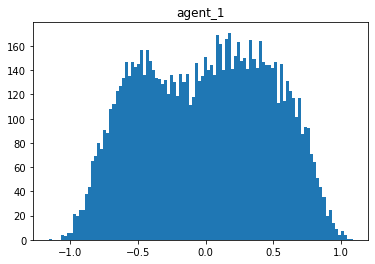

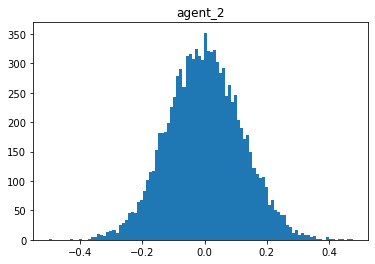

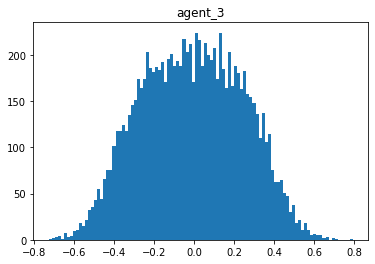

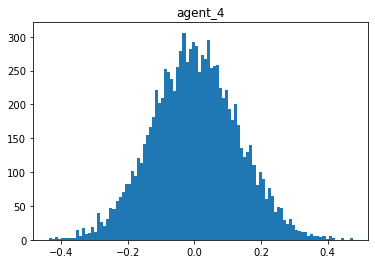

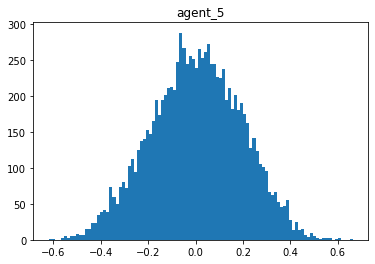

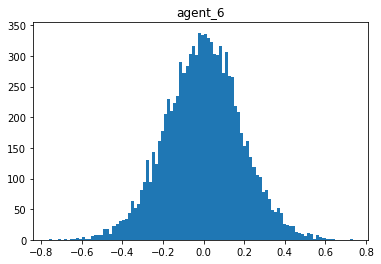

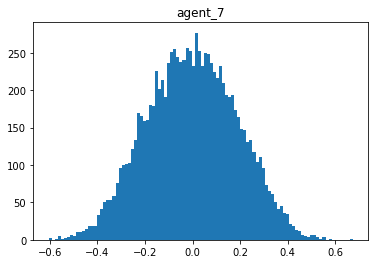

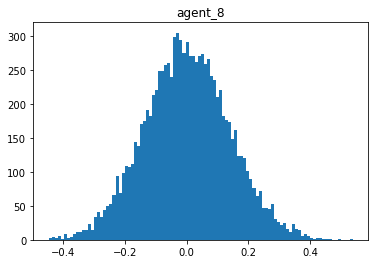

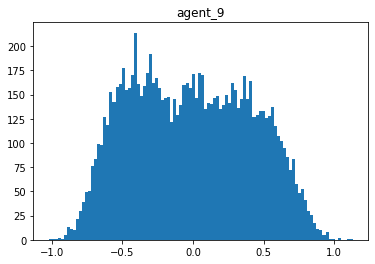

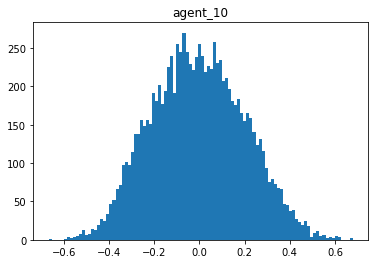

In [24]:
count=1
for ta in table_actions_explored:
    plt.hist(ta, bins = 100)
    plt.title("agent_{}".format(count))
    #plt.savefig("C:/Users/Thomas/Documents/3A/projet DPRL/ac3.0_M100_T100_tau(1e-2)_lrc(1e-1)_lrea(1e-3)_alpha=1_sigma=0.1/agent_{}_action_explored_train.png".format(count))
    plt.show()
    count+=1

In [81]:
df = pd.read_csv('./data/IBM_test.csv')
df = df.sort_values('Date')
env = StockTradingEnv(df)


df_results = pd.DataFrame(columns=['Date','Index','agent_1','agent_2','agent_3','agent_4','agent_5','agent_6','agent_7','agent_8','agent_9','agent_10','agent_11','agent_12','agent_13','agent_14','agent_15','agent_16','agent_17','agent_18','agent_19','agent_20','action_1','action_2','action_3','action_4','action_5','action_6','action_7','action_8','action_9','action_10','action_11','action_12','action_13','action_14','action_15','action_16','action_17','action_18','action_19','action_20','action_smooth_1','action_smooth_2','action_smooth_3','action_smooth_4','action_smooth_5','action_smooth_6','action_smooth_7','action_smooth_8','action_smooth_9','action_smooth_10','action_smooth_11','action_smooth_12','action_smooth_13','action_smooth_14','action_smooth_15','action_smooth_16','action_smooth_17','action_smooth_18','action_smooth_19','action_smooth_20','agent_mean'], index=df.index)
df_results['Date'] = df['Date']

table_actions = []
last_net_worth = []
# Compute the Index value
for i in range(len(df.loc[:, 'Open'].values) - 6):
    df_results.loc[i+5, "Index"] = df.loc[i+5, "Close"] * env.initial_account_balance / df.loc[5, "Close"] # i + 5 bec
    

count = 1
# Compute the Agents' net_worth
for Agent in agents:
    
    observation = env.reset_to_day_one().astype('float32')
    observation = np.expand_dims(observation,axis=0)
    observation = np.expand_dims(observation,axis=0)
    observation = tf.convert_to_tensor(observation)  
    table_actions_agent=[]
    for i in range(len(df.loc[:, 'Open'].values) - 6):
        action = Agent(observation)
        action = tf.squeeze(action)
        df_results.loc[i+5,'action_{}'.format(count)] = action.numpy()
        table_actions_agent.append(action.numpy())
        #df_results.loc[i+5,'action_smooth'] = 0.8*df_results.loc[i+4,'action_smooth']+0.2*df_results.loc[i+5,'action']
        #print(action)
        action = D.convert_action(action)
        
         
        observation, reward, done, _ = env.step(action)
        observation = np.expand_dims(observation,axis=0)
        observation = np.expand_dims(observation,axis=0)
        observation = tf.convert_to_tensor(observation) 
        df_results.loc[i+5, "agent_{}".format(count)] = env.net_worth   

        print("\r agent_{}, day {} out of {}".format(count, i, len(df.loc[:, 'Open'].values) - 7), end = "")
    print("")
    table_actions.append(table_actions_agent)
    count +=1
    print("last net_worth: {}".format(env.net_worth))
    last_net_worth.append(env.net_worth)
    


 agent_1, day 999 out of 999
last net_worth: 10130.540988000006
 agent_2, day 999 out of 999
last net_worth: 9332.459928999995
 agent_3, day 999 out of 999
last net_worth: 11107.749891000003
 agent_4, day 999 out of 999
last net_worth: 10029.010222000008
 agent_5, day 999 out of 999
last net_worth: 9745.230044
 agent_6, day 999 out of 999
last net_worth: 9231.189127000012
 agent_7, day 999 out of 999
last net_worth: 10279.420157999995
 agent_8, day 999 out of 999
last net_worth: 10176.210200000005
 agent_9, day 999 out of 999
last net_worth: 11832.10809
 agent_10, day 999 out of 999
last net_worth: 10530.430285000006


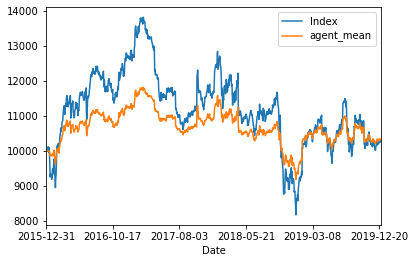

In [82]:
df_results['agent_mean'] = df_results[['agent_1','agent_10']].mean(axis=1)
fig = df_results.plot(x="Date", y=["Index","agent_mean"]).get_figure()
fig.savefig("C:/Users/Thomas/Documents/3A/projet DPRL/IBM_test_agent_mean_over_10.png")

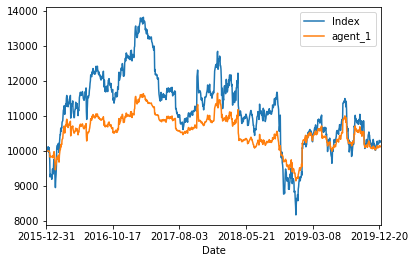

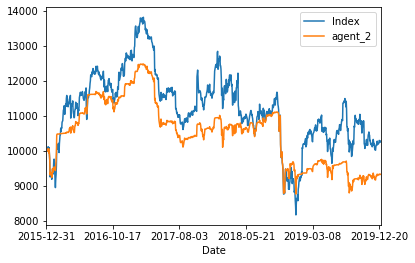

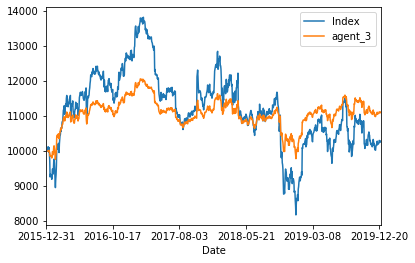

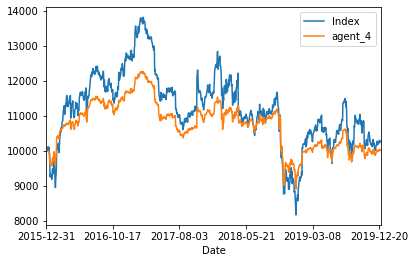

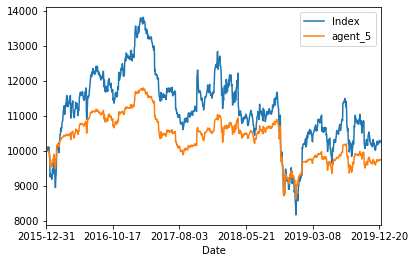

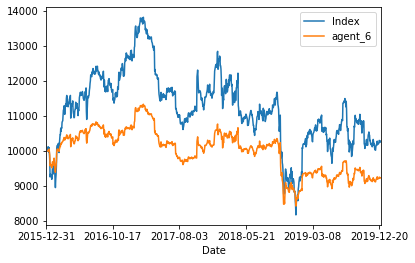

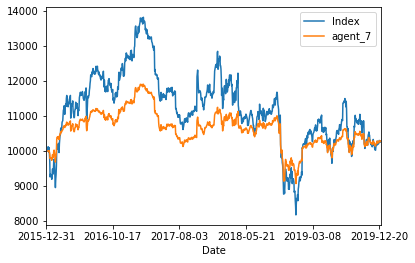

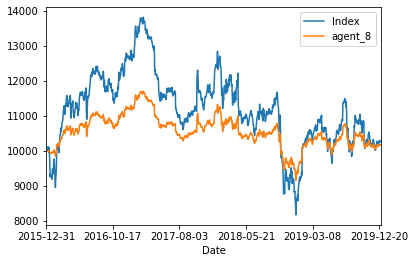

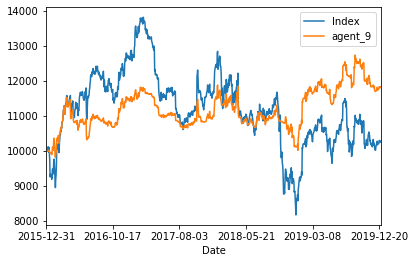

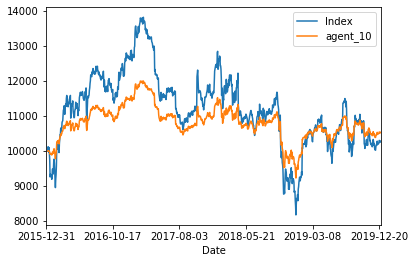

In [83]:

count = 1
for Agent in agents:
    
    fig = df_results.plot(x="Date", y=["Index","agent_{}".format(count)]).get_figure()
    #fig.savefig("C:/Users/Thomas/Documents/3A/projet DPRL/ac3.0_M100_T100_tau(1e-2)_lrc(1e-1)_lrea(1e-3)_alpha=1_sigma=0.1/agent_{}_IBM_test_last_net_worth={}.png".format(count,last_net_worth[count-1]))
    #df_results['action_smooth_{}'.format(count)] = smoothTriangle(df_results["action_{}".format(count)], 50)
    #df_results['action_smooth'] = df_results["action"].rolling(window=100).mean()
    #fig2 = df_results.plot(x="Date", y=["action_smooth_{}".format(count)]).get_figure()
    #fig2.savefig("C:/Users/Thomas/Documents/3A/projet DPRL/ac2.0_M50_T100_tau(1e-2)_lrc(1e-1)_lrea(1e-3)_alpha=1_sigma=0.2/agent_{}_action_on_val_smooth.png".format(count))
    count+=1


In [84]:
#agents[9].save_weights("save_models_ac/best_agent_val_10000",save_format="tf")

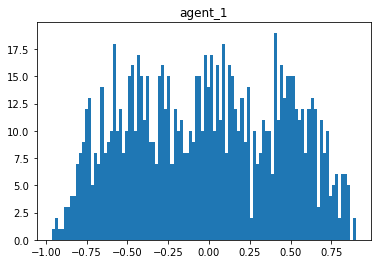

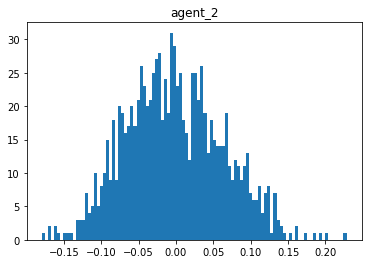

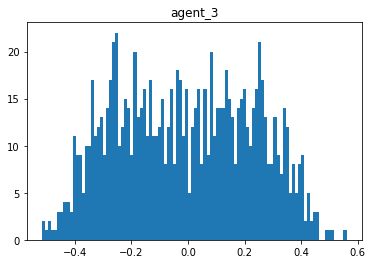

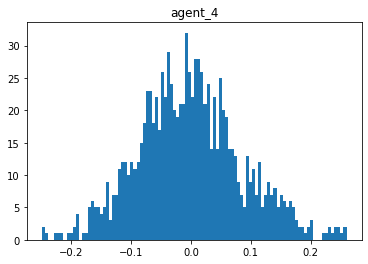

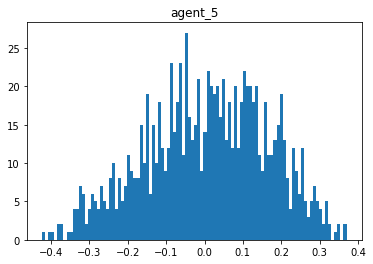

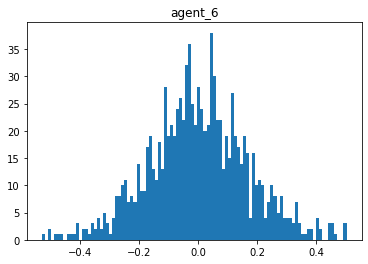

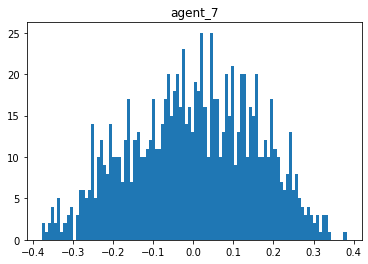

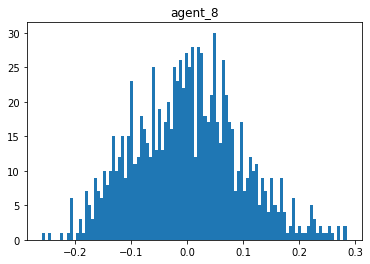

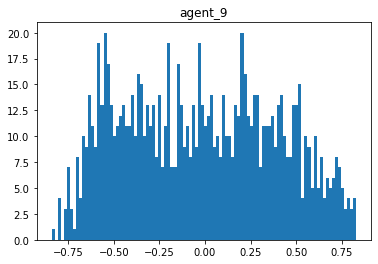

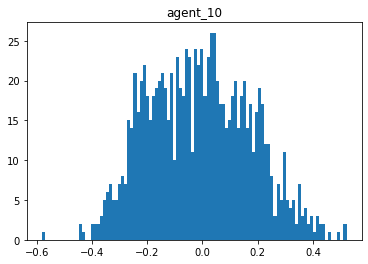

In [34]:
count=1
for ta in table_actions:
    
    plt.hist(ta, bins = 100)
    plt.title("agent_{}".format(count))
    plt.savefig("C:/Users/Thomas/Documents/3A/projet DPRL/ac3.0_M100_T100_tau(1e-2)_lrc(1e-1)_lrea(1e-3)_alpha=1_sigma=0.1/agent_{}_action_realized_IBM_test.png".format(count))
    plt.show()
    count+=1

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [70]:
df_results["Index"][5:-8].values - df_results["Index"][6:-7].values

array([-121.55214914714816, 25.070423722920168, 131.42869667140076,
       -132.18916158211687, 218.7954790399017, 145.86324751715983,
       474.81575344466546, -79.76927449026516, 31.148217308053063,
       31.907466690439833, -38.744509657961316, 123.83172058680611,
       -95.72300783548599, -195.2442378164451, -3.0388967925664474,
       143.58428384166655, -135.22745061052046, -222.59370118537845,
       -69.89325875965915, 120.79343155840616, 221.0744427153968,
       294.76546779740784, 177.77132197176434, -242.34618846971898,
       -129.14965702538575, -255.26094905185164, -482.4127295292601,
       -47.86180779982533, -52.419811121331804, 104.08037286027684,
       -30.388891955144572, -129.14965702538575, 187.64726173185045,
       75.97052055114727, -253.74123475874694, -146.62371242787776,
       -113.95578082671818, 0.0, -178.53003956050816, 82.04717457846891,
       -101.8002696269723, 16.713666462292167, -164.855953625467,
       -31.907466690439833, -13.67530146337594

In [71]:
decrease = (df_results["Index"][5:-7].values - df_results["Index"][6:-6].values) <= 0
y_true = decrease.astype(int)
t_act = np.array(table_actions[9])
actions = t_act[5:-1] <= 0
y_pred = actions.astype(int)
print(y_true)
print(y_pred)


[1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1
 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1
 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1
 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0
 0 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0
 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1
 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0
 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0
 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1
 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1
 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0
 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0
 0 0 1 1 1 0 1 0 1 0 0 0 

In [72]:
accuracy_score(y_true, y_pred)

0.5442655935613682

In [73]:
confusion_matrix(y_true, y_pred)

array([[239, 225],
       [228, 302]], dtype=int64)

In [43]:
count=1
for Agent in agents: 
    diff = df_results["agent_{}".format(count)][5:-1] - df_results["Index"][5:-1]
    score = diff.mean()
    print(score)
    count+=1

326.78278658264907
-56.366988854345436
149.0038529286561
240.58007413566148
-499.7933419703387
-527.8624893983424
122.84929294465006
107.45664125465665
416.5148079486577
424.598513171658


In [45]:
count=1
for Agent in agents: 
    diff = df_results["agent_{}".format(count)][5:-1] - df_results["Index"][5:-1]
    score = diff.mean()
    print(score)
    count+=1

-1238.7667074555043
-494.41427448151705
-731.0748957215023
-544.6890780425163
-431.01053233851957
-264.88868760051525
196.866210428479
-607.7732569115219
-1041.2380997265075
-1070.427085577517


 agent_1, day 0 out of 999WARNING:tensorflow:Layer stock_actor_11 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

 agent_1, day 999 out of 999
last net_worth: 8314.929765000008


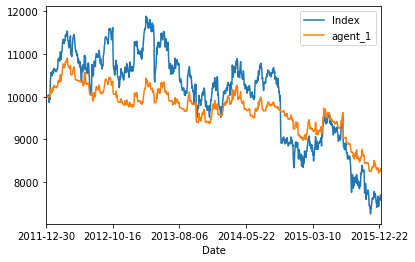

In [9]:
df = pd.read_csv('./data/IBM_val.csv')
df = df.sort_values('Date')
env = StockTradingEnv(df)

D = DQN( 0.99, 365, 100, 32, 10e-1,10e-3)

df_results = pd.DataFrame(columns=['Date','Index','agent_1','agent_2','agent_3','agent_4','agent_5','agent_6','agent_7','agent_8','agent_9','agent_10','agent_11','agent_12','agent_13','agent_14','agent_15','agent_16','agent_17','agent_18','agent_19','agent_20','action_1','action_2','action_3','action_4','action_5','action_6','action_7','action_8','action_9','action_10','action_11','action_12','action_13','action_14','action_15','action_16','action_17','action_18','action_19','action_20','action_smooth_1','action_smooth_2','action_smooth_3','action_smooth_4','action_smooth_5','action_smooth_6','action_smooth_7','action_smooth_8','action_smooth_9','action_smooth_10','action_smooth_11','action_smooth_12','action_smooth_13','action_smooth_14','action_smooth_15','action_smooth_16','action_smooth_17','action_smooth_18','action_smooth_19','action_smooth_20','agent_mean'], index=df.index)
df_results['Date'] = df['Date']

table_actions = []
last_net_worth = []
count = 1
# Compute the Index value
for i in range(len(df.loc[:, 'Open'].values) - 6):
    df_results.loc[i+5, "Index"] = df.loc[i+5, "Close"] * env.initial_account_balance / df.loc[5, "Close"] # i + 5 bec

act = StockActor()
act.load_weights("save_models_ac/agent_9_10000")

observation = env.reset_to_day_one().astype('float32')
observation = np.expand_dims(observation,axis=0)
observation = np.expand_dims(observation,axis=0)
observation = tf.convert_to_tensor(observation)

for i in range(len(df.loc[:, 'Open'].values) - 6):
    action = act(observation)
    action = tf.squeeze(action)


    action = D.convert_action(action)
        
    observation, reward, done, _ = env.step(action)
    observation = np.expand_dims(observation,axis=0)
    observation = np.expand_dims(observation,axis=0)
    observation = tf.convert_to_tensor(observation)  
    df_results.loc[i+5, "agent_{}".format(count)] = env.net_worth
    
    print("\r agent_{}, day {} out of {}".format(count, i, len(df.loc[:, 'Open'].values) - 7), end = "")
print("")


print("last net_worth: {}".format(env.net_worth))
last_net_worth.append(env.net_worth)

fig = df_results.plot(x="Date", y=["Index","agent_{}".format(count)]).get_figure()

start = time.time()
DDPG(10,100,lrc,lra)          
end = time.time()                     # 10t par seconde
print(end - start)

######modify return of DDPG remove the other returns and put table_loss
table_loss = []
iteration = 2
lr = [1e-1,1e-2,1e-3,1e-4]
for i in range(iteration):
    table_it = []
    for lrc in lr:
        table_lrc = []
        for lra in lr: 
            table_lrc.append(DDPG(10,100,lrc,lra))
            
        table_it.append(table_lrc) 
    table_loss.append(table_it)
    
    print(" ")
    print(i)
    print(" ")


t = np.arange(0, 1000, 1)
table_loss  = np.asarray(table_loss)
max_table = np.amax(table_loss)
norm_table_loss = np.divide(table_loss,max_table)

everage = np.sum(table_loss ,axis=0)/iteration


for j in range(4):
    for k in range(4):
        
        s_everage = smoothTriangle(everage[j][k], 10)
        plt.plot(t,everage[j][k], label="everage loss")
        plt.plot(t,s_everage, label="smooth everage loss")
        plt.xlabel("t")
        plt.ylabel(" loss")
        plt.legend()
        plt.title("everage loss with lr_crit={} and lr_act={}".format(lr[j], lr[k]))
        plt.show()
        
        for i in range(iteration):
            
            s = smoothTriangle(table_loss[i][j][k], 10)
            plt.plot(t,table_loss[i][j][k],label="loss")
            plt.plot(t,s,label="smooth loss")
            plt.xlabel("t")
            plt.ylabel("loss")
            plt.legend()
            plt.title("loss with lr_crit={} and lr_act={}".format(lr[j], lr[k]))
            plt.show()



t= np.arange(0, 1000, 1)


def smooth_average (tble_loss):
    smooth=[]
    for i in range(1000):
        
        if i<=9:
            s=0
            for j in range(10):
                index = i+j
                s= s+ tble_loss[index]
            smooth.append(s/10)
        elif i>=989:
            s=0
            for j in range(10):
                index = i-j
                s= s+ tble_loss[index]
            smooth.append(s/10)        
        else:
            s=0
            for j in range(22):
                index = i-10+j
                s= s+ tble_loss[index]
            smooth.append(s/21)
    return smooth

s = smooth_average (table_loss)
s_2 = smooth_average (table_loss_2)
s_3 = smooth_average (table_loss_3)
s_4 = smooth_average (table_loss_4)
s_5 = smooth_average (table_loss_5)


everage = []
for i in range(1000):
    everage.append((table_loss[i]+table_loss_2[i]+table_loss_3[i]+table_loss_4[i]+table_loss_5[i])/5)
    
s_everage = smooth_average(everage)

f = plt.figure(1)
plt.plot(t,table_loss)
plt.plot(t,s)
f.show()
g = plt.figure(2)
plt.plot(t,table_loss_2)
plt.plot(t,s_2)
g.show()
h = plt.figure(3)
plt.plot(t,table_loss_3)
plt.plot(t,s_3)
h.show()
i = plt.figure(4)
plt.plot(t,table_loss_4)
plt.plot(t,s_4)
i.show()
j = plt.figure(5)
plt.plot(t,table_loss_5)
plt.plot(t,s_5)
j.show()
k = plt.figure(6)
plt.plot(t,everage)
plt.plot(t,s_everage)
k.show()


print(table_loss_2[999])
em = np.empty([1])
print(em)
em = np.append(em,[1.3])
print(em)